In [ ]:
!pip install -U spacy

     |████████████████████████████████| 12.8MB 206kB/s 
     |████████████████████████████████| 9.1MB 46.4MB/s 
     |████████████████████████████████| 460kB 50.2MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 1.1MB 44.7MB/s 
     |████████████████████████████████| 122kB 57.5MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=948234c0a93c3e256b1d76f019017a940ae14494815e605328941d7a3dc54a0a
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: smart-open 5.0.0
    Uninstalling smart-open-5.0.0:
      Successfully uninstalled smart-open-

In [ ]:
!python -m spacy download ru_core_news_sm

2021-05-30 19:22:23.885418: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 17.9MB 178kB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 8.2MB 44.3MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
!git clone https://github.com/feralvam/easse.git && cd easse && pip install .

fatal: destination path 'easse' already exists and is not an empty directory.


In [ ]:
import nltk

In [ ]:
from string import punctuation
punkt = punctuation + "''«»"

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from torchtext.data.metrics import bleu_score
# from easse.sari import corpus_sari

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
spacy_ru = spacy.load("ru_core_news_sm")

In [ ]:
def tokenize_ru1(text):
    """
    Tokenizes Russian text from a string into a list of strings (tokens) and reverses it
    """
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'<.*?>',' ', text)
    text = re.sub(r'\d+',' ', text)
    text = re.sub(r'#\w+',' ', text)
    text = re.sub(r'@\w+',' ', text)

    return [tok.text for tok in spacy_ru.tokenizer(text) if tok.text != " " and tok.text != ""\
              and tok.text.strip() not in punkt] #[::-1]

In [ ]:
def tokenize_ru2(text):
    """
    Tokenizes Russian text from a string into a list of strings (tokens)
    """
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'<.*?>',' ', text)
    text = re.sub(r'\d+',' ', text)
    text = re.sub(r'#\w+',' ', text)
    text = re.sub(r'@\w+',' ', text)

    return [tok.text for tok in spacy_ru.tokenizer(text) if tok.text != " " and tok.text != ""\
              and tok.text.strip() not in punkt]

In [ ]:
SRC = Field(sequential = True, 
            use_vocab = True, 
            tokenize = tokenize_ru1, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True)

TRG = Field(sequential = True, 
            use_vocab = True,
            tokenize = tokenize_ru2, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}

In [ ]:
train_data, valid_data, test_data = TabularDataset.splits(
                                                          path = '/content/drive/MyDrive/datasets/diplom',
                                                          train = 'train_n.csv',
                                                          validation = 'valid_n.csv',
                                                          test = 'test_n.csv',
                                                          format = 'csv',
                                                          fields = fields)

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 124172
Number of validation examples: 15521
Number of testing examples: 15522


In [ ]:
print(vars(train_data.examples[10]))

{'src': ['сарабанда', 'вдохновила', 'название', 'последнего', 'фильма', 'ингмара', 'бергмана', 'сарабанда'], 'trg': ['сарабанда', 'много', 'использовалась', 'в', 'фильмах', 'в', 'том', 'числе', 'в', 'фильме', 'ингмара', 'бергмана', 'сарабанда']}


In [ ]:
SRC.build_vocab(train_data, min_freq = 10)
TRG.build_vocab(train_data, min_freq = 10)

In [ ]:
print(f"Unique tokens in source vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target vocabulary: {len(TRG.vocab)}")

Unique tokens in source vocabulary: 23379
Unique tokens in target vocabulary: 19375


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        attention = self.v(energy).squeeze(2)
                
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        input = input.unsqueeze(0)
                
        embedded = self.dropout(self.embedding(input))
                
        a = self.attention(hidden, encoder_outputs, mask)
                        
        a = a.unsqueeze(1)
                
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
                
        weighted = torch.bmm(a, encoder_outputs)
                
        weighted = weighted.permute(1, 0, 2)
                
        rnn_input = torch.cat((embedded, weighted), dim = 2)
                    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
                
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        input = trg[0,:]
        
        mask = self.create_mask(src)
                
        for t in range(1, trg_len):
            
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1
            
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(23379, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(19375, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=19375, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 52,117,679 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
      
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            
            trg = batch.trg

            output = model(src, src_len, trg, 0) 

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def save_checkpoint(model, optimizer, save_path, epoch, train_loss, valid_loss, best_valid_loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), #добавить train и valid loss
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'best_valid_loss': best_valid_loss,
        'epoch': epoch+1
    }, save_path)

In [ ]:
def load_checkpoint(load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    valid_loss = checkpoint['valid_loss']
    best_valid_loss = checkpoint['best_valid_loss']

    
    return model, optimizer, epoch, train_loss, valid_loss, best_valid_loss

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/datasets/diplom/models/tut44-model.pt') #оригинал 4 #41 с прямым порядком слов #42 частотность 5 токенов #43 прямой + 5 токенов

    save_checkpoint(model, optimizer, '/content/drive/MyDrive/datasets/diplom/checkpoints/checkpoint44.pth', epoch, train_loss, valid_loss, best_valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 8m 42s
	Train Loss: 5.295 | Train PPL: 199.291
	 Val. Loss: 4.756 |  Val. PPL: 116.329
Epoch: 02 | Time: 8m 41s
	Train Loss: 3.734 | Train PPL:  41.841
	 Val. Loss: 4.417 |  Val. PPL:  82.878
Epoch: 03 | Time: 8m 41s
	Train Loss: 3.048 | Train PPL:  21.076
	 Val. Loss: 4.488 |  Val. PPL:  88.925
Epoch: 04 | Time: 8m 41s
	Train Loss: 2.672 | Train PPL:  14.473
	 Val. Loss: 4.534 |  Val. PPL:  93.129
Epoch: 05 | Time: 8m 42s
	Train Loss: 2.411 | Train PPL:  11.150
	 Val. Loss: 4.568 |  Val. PPL:  96.388
Epoch: 06 | Time: 8m 40s
	Train Loss: 2.227 | Train PPL:   9.273
	 Val. Loss: 4.591 |  Val. PPL:  98.611
Epoch: 07 | Time: 8m 42s
	Train Loss: 2.081 | Train PPL:   8.012
	 Val. Loss: 4.701 |  Val. PPL: 110.101
Epoch: 08 | Time: 8m 43s
	Train Loss: 1.980 | Train PPL:   7.241
	 Val. Loss: 4.758 |  Val. PPL: 116.497
Epoch: 09 | Time: 8m 42s
	Train Loss: 1.895 | Train PPL:   6.652
	 Val. Loss: 4.877 |  Val. PPL: 131.263
Epoch: 10 | Time: 8m 42s
	Train Loss: 1.829 | Train PPL

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/diplom/models/tut44-model.pt')) # 4 #41 прямой порядок #42 5 токенов

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.427 | Test PPL:  83.713 |


In [ ]:
model, optimizer, epoch_n, train_loss, valid_loss, best_valid_loss  = load_checkpoint('/content/drive/MyDrive/datasets/diplom/checkpoints/checkpoint44.pth')

### BLEU and EASSE

In [ ]:
def simplify_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('ru_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:-1]

In [ ]:
def simplify_sentence2(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
def display_attention(sentence, simplification, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + simplification
     
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
i = 177 #345 #268 #184 #142 #139
src = vars(test_data.examples[i])['src']
trg = vars(test_data.examples[i])['trg']
simplification, attention = simplify_sentence2(src, SRC, TRG, model, device)

In [ ]:
print(f'predicted trg = {simplification}')
print(f'src = {src}')
print(f'trg = {trg}')

predicted trg = ['это', '<unk>', '<unk>', '<unk>', 'на', '<unk>', 'и', 'брюки', 'которые', 'женщины', 'так', 'и', 'женщины', '<eos>']
src = ['это', 'платье', 'унисекс', 'похожее', 'на', 'рубашку', 'и', 'брюки', 'которые', 'носят', 'как', 'женщины', 'так', 'и', 'мужчины', 'на', 'западе']
trg = ['салвар', 'камиз', 'также', 'пишется', 'как', 'шальвар', 'камиз', 'или', 'шальвар', 'камиз', 'это', 'традиционная', 'одежда', 'которую', 'носят', 'как', 'женщины', 'так', 'и', 'мужчины', 'в', 'южной', 'азии']


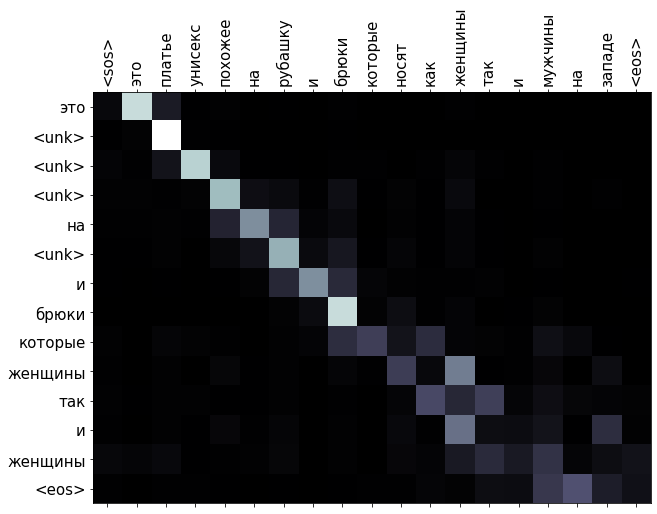

In [ ]:
display_attention(src, simplification, attention)

In [ ]:
for i in range(1000):
  src = vars(test_data.examples[i])['src']
  trg = vars(test_data.examples[i])['trg']
  print(i)
  print(f'src = {src}')
  print(f'trg = {trg}')
  simple = simplify_sentence(src, SRC, TRG, model, device, max_len=50)
  print(f'simple = {simple}')
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
0
src = ['книга', 'претендует', 'на', 'то', 'чтобы', 'быть', 'настоящим', 'дневником', 'анонимной', 'девочки', 'подростка', 'которая', 'пристрастилась', 'к', 'наркотикам', 'и', 'представлена', 'как', 'свидетельство', 'против', 'употребления', 'наркотиков']
trg = ['говорят', 'что', 'эта', 'книга', 'настоящий', 'дневник', 'анонимной', 'девочки', 'подростка', 'которая', 'пристрастилась', 'к', 'наркотикам']
simple = ['книга', 'претендует', 'на', 'то', 'чтобы', 'быть', 'настоящим', '<unk>', '<unk>', 'девушки', 'которую', '<unk>', 'к', '<unk>', 'и', '<unk>', 'как', '<unk>', 'против', '<unk>', 'наркотиков']

1
src = ['точно', 'так', 'же', 'зонтичная', 'организация', 'это', 'центральный', 'и', 'координирующий', 'орган', 'представляющий', 'ряд', 'более', 'мелких', 'отдельных', 'органов']
trg = ['точно', 'так', 'же', 'зонтичная', 'группа', 'может', 'быть', 'организацией', 'которая', 'является', 'центральным', 'и', 'координирующи

In [ ]:
for i in range(50):
  src = vars(valid_data.examples[i])['src']
  trg = vars(valid_data.examples[i])['trg']
  print(f'src = {src}')
  print(f'trg = {trg}')
  simple = simplify_sentence(src, SRC, TRG, model, device, max_len=50)
  print(f'simple = {simple}')
  print()

In [ ]:
for i in range(50):
  src = vars(test_data.examples[i])['src']
  trg = vars(test_data.examples[i])['trg']
  print(f'src = {src}')
  print(f'trg = {trg}')
  simple = simplify_sentence(src, SRC, TRG, model, device, max_len=50)
  print(f'simple = {simple}')
  print()

In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = simplify_sentence(src, src_field, trg_field, model, device, max_len)
        
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

In [ ]:
print(f'BLEU score = {bleu_score*100:.2f}')

17.34

15.41

### top bleu scores

In [ ]:
def calculate_bleu2(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    bleus = []
    srcs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = simplify_sentence(src, src_field, trg_field, model, device, max_len=50)
        
        pred_trg = pred_trg[:-1]

        bl = bleu_score([trg], [[pred_trg]])
        
        pred_trgs.append([pred_trg])
        trgs.append([trg])
        bleus.append(bl)
        srcs.append([src[::-1]])
        
        
    return pred_trgs, trgs, bleus, srcs

In [ ]:
pred_trgs, trgs, bleus, srcs = calculate_bleu2(test_data, SRC, TRG, model, device, max_len = 50)

In [ ]:
ix = [i for i in range(15522)]

In [ ]:
dict = {'src': srcs, 'trg': trgs, 'smpl': pred_trgs, 'score': bleus, 'ix': ix} 

In [ ]:
df = pd.DataFrame(dict)

In [ ]:
df

,src,trg,smpl,score,ix
0,"[[книга, претендует, на, то, чтобы, быть, наст...","[[говорят, что, эта, книга, настоящий, дневник...","[[книга, <unk>, на, то, чтобы, быть, настоящим...",0.000000,0
1,"[[точно, так, же, зонтичная, организация, это,...","[[точно, так, же, зонтичная, группа, может, бы...","[[точно, так, же, <unk>, организация, это, цен...",0.000000,1
2,"[[это, совместная, резиденция, епархии, тарб, ...","[[это, совместная, резиденция, епархии, тарб, ...","[[это, дом, резиденцией, <unk>, <unk>, и, и, м...",0.000000,2
3,"[[курсель, ла, фор, êt, это, коммуна, в, депар...","[[он, находится, в, регионе, пэи, де, ла, луар...","[[он, находится, в, регионе, пэи, де, ла, луар...",0.919323,3
4,"[[гестрикланд, самая, южная, из, провинций, но...","[[провинция, является, самым, южным, районом, ...","[[<unk>, одна, из, из, <unk>]]",0.000000,4
...,...,...,...,...,...
15517,"[[скайлайн, город, в, округе, голубая, земля, ...","[[скайлайн, город, в, округе, голубая, земля, ...","[[<unk>, город, в, штате, голубая, штат]]",0.000000,15517
15518,"[[караббия, район, города, лугано, швейцария]]","[[караббия, это, муниципалитет, района, лугано...","[[<unk>, район, в, лугано, в, кантоне, тичино,...",0.392815,15518
15519,"[[главный, госпиталь, был, создан, мужем, и, ж...","[[сериал, создали, сценаристы, мыла, фрэнк, и,...","[[главный, филиал, был, создан, мужем, и, <unk...",0.000000,15519
15520,"[[в, начале, октября, в, западной, части, атла...","[[ранним, утром, октября, национальный, центр,...","[[в, начале, октября, года, в, <unk>, части, а...",0.000000,15520


In [ ]:
df = df.sort_values(by=['score'])

In [ ]:
df.tail(3000)

,src,trg,smpl,score,ix
2968,"[[это, ширина, от, кончика, большого, пальца, ...","[[размах, это, ширина, руки, человека, от, кон...","[[это, ширина, от, большого, большого, пальца,...",0.262025,2968
12348,"[[поэтому, расположение, точек, перед, словом,...","[[поэтому, расположение, точек, перед, словом,...","[[поэтому, расположение, точек, перед, <unk>, ...",0.262025,12348
4327,"[[близнецы, распространены, у, многих, видов, ...","[[близнецы, распространены, у, многих, других,...","[[у, многих, видов, животных, таких, как, кошк...",0.262025,4327
925,"[[в, том, же, году, открылась, станция, clunes...","[[в, том, же, году, открылась, станция, clunes...","[[в, году, же, году, открылась, станция, <unk>...",0.262025,925
5649,"[[линии, размечаются, на, расстоянии, м, м, и,...","[[линии, размечены, на, расстоянии, м, м, и, м...","[[линии, <unk>, на, расстоянии, м, м, м, м, м,...",0.262025,5649
...,...,...,...,...,...
1941,"[[оркестр, был, записан, августа]]","[[оркестр, был, записан, августа]]","[[оркестр, был, записан, августа]]",1.000000,1941
8481,"[[у, нее, есть, старший, брат, кэмерон, стюарт]]","[[у, кристен, есть, старший, брат, кэмерон, ст...","[[у, кристен, есть, старший, брат, кэмерон, ст...",1.000000,8481
9351,"[[колдуэлл, каунти, округ, расположенный, в, ш...","[[колдуэлл, каунти, округ, в, штате, северная,...","[[колдуэлл, каунти, округ, в, штате, северная,...",1.000000,9351
3003,"[[ген, фактора, viii, расположен, на, x, хромо...","[[ген, фактора, viii, находится, на, х, хромос...","[[ген, фактора, viii, находится, на, х, хромос...",1.000000,3003


In [ ]:
df.to_csv('/content/drive/MyDrive/datasets/diplom/attn_bleu_scores.csv')

### SARI

In [ ]:
def calculate_sari(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    origs = []

    for datum in data:
      src = vars(datum)['src']
      trg = vars(datum)['trg']

      pred_trg = simplify_sentence(src, src_field, trg_field, model, device, max_len)
      pred_trg = pred_trg[:-1]

      src_s = ' '.join(src)
      trg_s = ' '.join(trg)
      simple_s = ' '.join(pred_trg)

      pred_trgs.append(simple_s)
      trgs.append(trg_s)
      origs.append(src_s)

    sari_score = corpus_sari(orig_sents=origs, sys_sents=pred_trgs, refs_sents=[trgs])

    return sari_score

In [ ]:
sari_score = calculate_sari(test_data, SRC, TRG, model, device)

In [ ]:
print(f'SARI score  = {sari_score}')

SARI score  = 37.35756851146696


47.55619028694159

37.35756851146696

In [ ]:
refs_f = pd.read_csv('/content/drive/MyDrive/datasets/diplom/ref_sents_filtered.csv')

In [ ]:
import ast

In [ ]:
first_lst = []
second_lst = []
third_lst = []
fourth_lst = []
fifth_lst = []

for i, v in enumerate(refs_f['trg']):
  v = ast.literal_eval(v)
  if len(v) == 5:
    first_lst.append(v[0])
    second_lst.append(v[1])
    third_lst.append(v[2])
    fourth_lst.append(v[3])
    fifth_lst.append(v[4])

In [ ]:
origs = []
for i, v in enumerate(refs_f['trg']):
  v = ast.literal_eval(v)
  if len(v) == 5:
    origs.append(refs_f['src'][i])

In [ ]:
pred_trgs = []
for v in origs:
  v = tokenize_ru1(v)
  pred_trg = simplify_sentence(v, SRC, TRG, model, device, max_len=50)
  pred_trg = pred_trg[:-1]
  pred_trg = ' '.join(pred_trg)
  pred_trgs.append(pred_trg)

In [ ]:
pred_trgs[:50]

['<unk> популярен среди <unk> но но также используется крупными компаниями в <unk> <unk>',
 'австралия и новая зеландия с с законом о <unk> <unk>',
 'это <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> и <unk>',
 'в отличие от армении не <unk> данные о <unk> военных <unk> во время',
 '<unk> входит в <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>',
 '<unk> <unk> при <unk> <unk> <unk> болезни легких легких легких',
 '<unk> <unk> даже <unk> на острове революции и <unk> в <unk> <unk> <unk> военного округа',
 '<unk> <unk> <unk> <unk> и <unk> промышленность <unk> и <unk> промышленность <unk> и <unk>',
 'анализ <unk> показывает что что на боль и функции не <unk> в зависимости от <unk>',
 '<unk> товары также <unk> и <unk> изделия из дерева <unk> <unk> и <unk> <unk> <unk> <unk> из',
 'армию <unk> <unk> толпа <unk> <unk> <unk> <unk> <unk> <unk> <unk>',
 '<unk> обнаружили в <unk> города <unk> <unk> <u

In [ ]:
sari_score = corpus_sari(orig_sents=origs, sys_sents=pred_trgs, refs_sents=[first_lst, second_lst, third_lst, fourth_lst, fifth_lst])

In [ ]:
sari_score

33.6768908205515

33.74672091731039

33.6768908205515